## Imports

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier 

murder = pd.read_csv('murder_project.csv')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocessing

In [2]:
# Drop object with State being 'PAPSP8'
murder.drop(murder.loc[murder['State']=='PAPSP8'].index, inplace=True) 

# Drop objects with VicAge being 999
murder.drop(murder.loc[murder['VicAge']==999].index, inplace=True)

# Drop object with Relationship being undetermined
murder.drop(murder.loc[murder['Relationship']=='Relationship not determined'].index, inplace=True)

# Create dummy variables for every State object
states = [] 
for case in murder['State']:
  if case not in states:
    states.append(case)

def dummy_states(state):
    for entry in states:
        if state == entry:
            return states.index(entry)+1

murder['State'] = murder['State'].apply(dummy_states)

# Create dummy variables for every Homicide object
homicides = []
for case in murder['Homicide']:
  if case not in homicides:
    homicides.append(case)

for homicide in homicides:
    murder['Homicide'] =  murder['Homicide'].replace(homicide, homicides.index(homicide))

# Create dummy variables for every Situation object
situations = []
for case in murder['Situation']:
  if case not in situations:
    situations.append(case)

for situation in situations:
    murder['Situation'] =  murder['Situation'].replace(situation, situations.index(situation))

# Create dummy variables for every VicSex object
vic_sex = []
for case in murder['VicSex']:
  if case not in vic_sex:
    vic_sex.append(case)

for sex in vic_sex:
    murder['VicSex'] =  murder['VicSex'].replace(sex, vic_sex.index(sex))

# Create dummy variables for every VicRace object
vic_race = []
for case in murder['VicRace']:
  if case not in vic_race:
    vic_race.append(case)

for race in vic_race:
    murder['VicRace'] =  murder['VicRace'].replace(race, vic_race.index(race))

# Create dummy variables for every Weapon object
weapons = []
for case in murder['Weapon']:
  if case not in weapons:
    weapons.append(case)

for weapon in weapons:
    murder['Weapon'] =  murder['Weapon'].replace(weapon, weapons.index(weapon))

# Recategorizing classes
relations = []
for case in murder['Relationship']:
  if case not in relations:
    relations.append(case)

def recategorize_relations(relation):
    if relations.index(relation) in [1,3,8,10,12,21,27]:
      relation = 'Lover'
      return relation
    elif relations.index(relation) in [4,6,7,14,15,16,17,18,19,23,24,25]:
      relation = 'Family'
      return relation
    elif relations.index(relation) in [9,20]:
      relation = 'Ex-lover'
      return relation
    elif relations.index(relation) in [22,26]:
      relation = 'Employment'
      return relation
    elif relations.index(relation) in [0,13]:
      relation = 'Acquaintance'
      return relation
    else:
      return relation # 2: stranger, 5: friend, 11: neighbor

murder['Relationship'] = murder['Relationship'].apply(recategorize_relations)

# Create dummy variables for every Relationship object
relationships = []
for case in murder['Relationship']:
  if case not in relationships:
    relationships.append(case)


for relation in relationships:
    murder['Relationship'] =  murder['Relationship'].replace(relation, relationships.index(relation))

## Statistical facts

In [3]:
# Analysing the types and frequencies of victim-offender relationships

relations = []
for case in murder['Relationship']:
  if case not in relations:
    relations.append(case)
print("Current relationship classes: ", relations)

# Counting the number of:
count0 = 0   # Acquaintance
count1 = 0   # Lover
count2 = 0   # Stranger
count3 = 0   # Family
count4 = 0   # Friend
count5 = 0   # Ex-lover
count6 = 0   # Neighbor
count7 = 0   # Employment

for case in murder['Relationship']:
    if case == relations[0]:
        count0 += 1
    elif case == relations[1]:
        count1 += 1
    elif case == relations[2]:
        count2 += 1
    elif case == relations[3]:
        count3 += 1
    elif case == relations[4]:
        count4 += 1
    elif case == relations[5]:
        count5 += 1
    elif case == relations[6]:
        count6 += 1
    elif case == relations[7]:
        count7 += 1

# Printing the proportion and the counts for each class
print('Total cases: {}'.format(len(murder)))
print('{}: {:.2f}% ({})'.format(relations[0], count0/len(murder)*100, count0))
print('{}: {:.2f}% ({})'.format(relations[1], count1/len(murder)*100, count1))
print('{}: {:.2f}% ({})'.format(relations[2], count2/len(murder)*100, count2))
print('{}: {:.2f}% ({})'.format(relations[3], count3/len(murder)*100, count3))
print('{}: {:.2f}% ({})'.format(relations[4], count4/len(murder)*100, count4))
print('{}: {:.2f}% ({})'.format(relations[5], count5/len(murder)*100, count5))
print('{}: {:.2f}% ({})'.format(relations[6], count6/len(murder)*100, count6))
print('{}: {:.2f}% ({})'.format(relations[7], count7/len(murder)*100, count7))

Current relationship classes:  [0, 1, 2, 3, 4, 5, 6, 7]
Total cases: 501876
0: 38.93% (195382)
1: 16.04% (80503)
2: 24.04% (120672)
3: 12.82% (64350)
4: 5.60% (28122)
5: 0.68% (3402)
6: 1.66% (8349)
7: 0.22% (1096)


In [4]:
# Analysing the frequencies of victim-offender situations

single_v = 0     # Single victim = 0 1 2
multiple_v = 0   # Multiple victims = 3 4 5
unknown_o = 0    # unknown offender = 0 5
single_o = 0     # single offender = 1 3
multiple_o = 0   # multiple offenders = 2 4

for case in murder['Situation']:
    if case == 0:
        single_v += 1
        unknown_o += 1
    elif case == 1:
        single_v += 1
        single_o += 1
    elif case == 2:
        single_v += 1 
        multiple_o += 1
    elif case == 3:
        multiple_v += 1
        single_o += 1
    elif case == 4:
        multiple_v += 1
        multiple_o += 1
    elif case == 5:
        multiple_v += 1
        unknown_o += 1

print('Single victim: {:.2f}%'.format(single_v/len(murder)*100))
print('Multiple victims: {:.2f}%'.format(multiple_v/len(murder)*100))
print('unknown offender: {:.2f}%'.format(unknown_o/len(murder)*100))
print('single offender: {:.2f}%'.format(single_o/len(murder)*100))
print('multiple offender: {:.2f}%'.format(multiple_o/len(murder)*100))

Single victim: 94.97%
Multiple victims: 5.03%
unknown offender: 76.19%
single offender: 15.60%
multiple offender: 8.21%


In [5]:
# Analysing the age of victims

age = 0

for case in murder['VicAge']:
    age += case

print('Average age of victims is: {:.2f}'.format(age/len(murder)))
print('Youngest age of victims is: {}'.format(min(murder['VicAge'])))
print('Oldest age of victims is: {}'.format(max(murder['VicAge'])))

Average age of victims is: 33.15
Youngest age of victims is: 0
Oldest age of victims is: 99


In [6]:
# Analysing the gender of victims

male = 0
female = 0
unknown = 0

for case in murder['VicSex']:
    if case == 0:
        male += 1
    elif case == 1:
        female += 1
    elif case == 2:
        unknown += 1

print('{}: {:.2f}%'.format(vic_sex[0], male/len(murder)*100))
print('{}: {:.2f}%'.format(vic_sex[1], female/len(murder)*100))
print('{}: {:.2f}%'.format(vic_sex[2], unknown/len(murder)*100))

Female: 26.16%
Male: 73.81%
Unknown: 0.02%


In [7]:
# Analysing the race of victims

black = 0
white = 0
asian = 0
AIorAN = 0
unknown = 0 
NHorPI = 0

for case in murder['VicRace']:
    if case == 0:
        black += 1
    elif case == 1:
        white += 1
    elif case == 2:
        asian += 1
    elif case == 3:
        AIorAN += 1
    elif case == 4:
        unknown += 1
    elif case == 5:
        NHorPI += 1

print('{}: {:.2f}%'.format(vic_race[0], black/len(murder)*100))
print('{}: {:.2f}%'.format(vic_race[1], white/len(murder)*100))
print('{}: {:.2f}%'.format(vic_race[2], asian/len(murder)*100))
print('{}: {:.2f}%'.format(vic_race[3], AIorAN/len(murder)*100))
print('{}: {:.2f}%'.format(vic_race[4], unknown/len(murder)*100))
print('{}: {:.2f}%'.format(vic_race[5], NHorPI/len(murder)*100))

Black: 42.40%
White: 54.24%
Asian: 1.60%
American Indian or Alaskan Native: 0.93%
Unknown: 0.81%
Native Hawaiian or Pacific Islander: 0.02%


In [8]:
# Analysing the incidents that have occured in that year previous of the said case

small_nr = 0
big_nr = 0

for case in murder['Incident']:
    if case < 10:
        small_nr += 1
    else:
        big_nr += 1

print('Previous year had less than 10 incidents: {:.2f}%'.format(small_nr/len(murder)*100))
print('Previous year had more than 10 incidents: {:.2f}%'.format(big_nr/len(murder)*100))

Previous year had less than 10 incidents: 80.94%
Previous year had more than 10 incidents: 19.06%


In [9]:
# Analysing the weapons used by offenders

count0 = 0   # Other or type unknown
count1 = 0   # Handgun - pistol, revolver, etc
count2 = 0   # Shotgun
count3 = 0   # Knife or cutting instrument
count4 = 0   # Blunt object - hammer, club, etc
count5 = 0   # Rifle
count6 = 0   # Personal weapons, includes beating
count7 = 0   # Firearm, type not stated
count8 = 0   # Drowning
count9 = 0   # Strangulation - hanging
count10 = 0  # Fire
count11 = 0  # Narcotics or drugs, sleeping pills
count12 = 0  # Asphyxiation - includes death by gas
count13 = 0  # Explosives
count14 = 0  # Poison - does not include gas
count15 = 0  # Pushed or thrown out window
count16 = 0  # Other gun

for case in murder['Weapon']:
    if case == 0:
        count0 += 1
    elif case == 1:
        count1 += 1
    elif case == 2:
        count2 += 1
    elif case == 3:
        count3 += 1
    elif case == 4:
        count4 += 1
    elif case == 5:
        count5 += 1
    elif case == 6:
        count6 += 1
    elif case == 7:
        count7 += 1
    elif case == 8:
        count8 += 1
    elif case == 9:
        count9 += 1
    elif case == 10:
        count10 += 1
    elif case == 11:
        count11 += 1
    elif case == 12:
        count12 += 1
    elif case == 13:
        count13 += 1
    elif case == 14:
        count14 += 1
    elif case == 15:
        count15 += 1
    elif case == 16:
        count16 += 1
  
print('{}: {:.2f}%'.format(weapons[0], count0/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[1], count1/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[2], count2/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[3], count3/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[4], count4/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[5], count5/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[6], count6/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[7], count7/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[8], count8/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[9], count9/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[10], count10/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[11], count11/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[12], count12/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[13], count13/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[14], count14/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[15], count15/len(murder)*100))
print('{}: {:.2f}%'.format(weapons[16], count16/len(murder)*100))

Other or type unknown: 3.87%
Handgun - pistol, revolver, etc: 47.85%
Shotgun: 6.26%
Knife or cutting instrument: 17.06%
Blunt object - hammer, club, etc: 4.55%
Rifle: 4.80%
Firearm, type not stated: 4.69%
Personal weapons, includes beating: 7.03%
Drowning: 0.24%
Fire: 0.95%
Strangulation - hanging: 1.07%
Narcotics or drugs, sleeping pills: 0.43%
Asphyxiation - includes death by gas: 0.73%
Explosives: 0.08%
Poison - does not include gas: 0.09%
Pushed or thrown out window: 0.04%
Other gun: 0.24%


## Assigning variables

In [10]:
feature_cols = ['State','Year', 'Incident','Homicide','Situation','VicAge', 'VicSex', 'VicRace', 'Weapon', 'VicCount']
X = murder[feature_cols] # Features
y = murder.Relationship # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

## The decision tree

In [11]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=13)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 
y_pred_proba = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba,multi_class = "ovr")
print("AUC:", auc_score)

Accuracy: 0.5175640761674515
AUC: 0.7408627453494769


## Confusion matrix of decision tree

In [12]:
# Creating Confusion matrix and computing error rate of decision tree classifier

'''
0. Acquaintance
1. Lover
2. Stranger
3. Family
4. Friend
5. Ex-lover
6. Neighbor
7. Employment
'''

y_relations0 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations1 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations2 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations3 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations4 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations5 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations6 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations7 = [0, 0, 0, 0, 0, 0, 0, 0]


for (test, pred) in zip(y_test, y_pred):
    if relationships[test] == 'Acquaintance':
        if relationships[pred] == 'Acquaintance':
            y_relations0[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations0[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations0[2] += 1
        elif relationships[pred] == 'Family':
            y_relations0[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations0[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations0[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations0[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations0[7] += 1
    elif relationships[test] == 'Lover':
        if relationships[pred] == 'Acquaintance':
            y_relations1[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations1[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations1[2] += 1
        elif relationships[pred] == 'Family':
            y_relations1[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations1[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations1[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations1[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations1[7] += 1
    elif relationships[test] == 'Stranger':
        if relationships[pred] == 'Acquaintance':
            y_relations2[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations2[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations2[2] += 1
        elif relationships[pred] == 'Family':
            y_relations2[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations2[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations2[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations2[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations2[7] += 1
    elif relationships[test] == 'Family':
        if relationships[pred] == 'Acquaintance':
            y_relations3[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations3[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations3[2] += 1
        elif relationships[pred] == 'Family':
            y_relations3[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations3[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations3[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations3[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations3[7] += 1
    elif relationships[test] == 'Friend':
        if relationships[pred] == 'Acquaintance':
            y_relations4[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations4[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations4[2] += 1
        elif relationships[pred] == 'Family':
            y_relations4[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations4[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations4[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations4[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations4[7] += 1
    elif relationships[test] == 'Ex-lover':
        if relationships[pred] == 'Acquaintance':
            y_relations5[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations5[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations5[2] += 1
        elif relationships[pred] == 'Family':
            y_relations5[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations5[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations5[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations5[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations5[7] += 1
    elif relationships[test] == 'Neighbor':
        if relationships[pred] == 'Acquaintance':
            y_relations6[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations6[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations6[2] += 1
        elif relationships[pred] == 'Family':
            y_relations6[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations6[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations6[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations6[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations6[7] += 1
    elif relationships[test] == 'Employment':
        if relationships[pred] == 'Acquaintance':
            y_relations7[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations7[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations7[2] += 1
        elif relationships[pred] == 'Family':
            y_relations7[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations7[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations7[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations7[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations7[7] += 1

print('y_test = Acquaintance --> y_pred: ', y_relations0)
print('y_test = Lover --> y_pred: ', y_relations1)
print('y_test = Stranger --> y_pred: ', y_relations2)
print('y_test = Family --> y_pred: ', y_relations3)
print('y_test = Friend --> y_pred: ', y_relations4)
print('y_test = Ex-lover --> y_pred: ', y_relations5)
print('y_test = Neighbor --> y_pred: ', y_relations6)
print('y_test = Employment --> y_pred: ', y_relations7)

print('Error of Acquaintance is: ', 100 - y_relations0[0]/sum(y_relations0)*100)
print('Error of Lover is: ', 100 - y_relations1[1]/sum(y_relations1)*100)
print('Error of Stranger is: ', 100 - y_relations2[2]/sum(y_relations2)*100)
print('Error of Family is: ', 100 - y_relations3[3]/sum(y_relations3)*100)
print('Error of Friend is: ', 100 - y_relations4[4]/sum(y_relations4)*100)
print('Error of Ex-lover is: ', 100 - y_relations5[5]/sum(y_relations5)*100)
print('Error of Neighbor is: ', 100 - y_relations6[6]/sum(y_relations6)*100)
print('Error of Employment is: ', 100 - y_relations7[7]/sum(y_relations7)*100)

y_test = Acquaintance --> y_pred:  [42357, 4971, 8148, 2766, 342, 0, 20, 2]
y_test = Lover --> y_pred:  [7904, 14234, 922, 1000, 89, 2, 0, 2]
y_test = Stranger --> y_pred:  [19979, 1892, 13271, 856, 200, 1, 19, 0]
y_test = Family --> y_pred:  [8373, 2022, 1216, 7497, 165, 0, 22, 0]
y_test = Friend --> y_pred:  [5409, 908, 1263, 331, 549, 0, 5, 2]
y_test = Ex-lover --> y_pred:  [277, 606, 45, 51, 1, 0, 0, 0]
y_test = Neighbor --> y_pred:  [1607, 318, 284, 256, 22, 2, 14, 0]
y_test = Employment --> y_pred:  [218, 36, 53, 30, 0, 0, 0, 4]
Error of Acquaintance is:  27.725830119782955
Error of Lover is:  41.06736223243489
Error of Stranger is:  63.35799878513446
Error of Family is:  61.14537444933921
Error of Friend is:  93.51600330695642
Error of Ex-lover is:  100.0
Error of Neighbor is:  99.44067119456652
Error of Employment is:  98.82697947214076


## ROC curve of decision tree

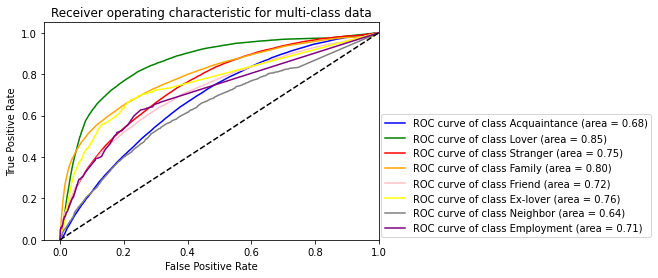

In [13]:
# Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7])
classes = y_bin.shape[1]

# Split dataset into training set and test set
X_train, X_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, test_size=0.3, random_state=1)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=13)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_bin_train)

# Predict the response for test dataset
y_pred_bin = clf.predict(X_test)

# Wrap classifier
classifier = OneVsRestClassifier(clf)
y_pred_proba = classifier.fit(X_train, y_bin_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Construct ROC curve
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = itertools.cycle(['blue', 'green', 'red', 'orange', 'pink', 'yellow', 'grey', 'purple'])

for i, color in zip(range(classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(relationships[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(bbox_to_anchor=(0.99, 0.6))
plt.show()

## Random forest

In [14]:
# Create Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=89, min_samples_split=2, random_state=0, max_depth=21)

# Train Random Forest Classifier
rf_clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred_rf = rf_clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_rf)))
y_pred_proba_rf = rf_clf.predict_proba(X_test)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf, multi_class = "ovr")
print("AUC:", auc_rf)

Accuracy: 0.5302232288145162
AUC: 0.7699777005967219


## Confusion matrix of random forest

In [15]:
# Creating Confusion matrix and computing error rate of random forest classifier


'''
0. Acquaintance
1. Lover
2. Stranger
3. Family
4. Friend
5. Ex-lover
6. Neighbor
7. Employment
'''

y_relations0 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations1 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations2 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations3 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations4 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations5 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations6 = [0, 0, 0, 0, 0, 0, 0, 0]
y_relations7 = [0, 0, 0, 0, 0, 0, 0, 0]


for (test, pred) in zip(y_test, y_pred_rf):
    if relationships[test] == 'Acquaintance':
        if relationships[pred] == 'Acquaintance':
            y_relations0[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations0[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations0[2] += 1
        elif relationships[pred] == 'Family':
            y_relations0[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations0[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations0[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations0[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations0[7] += 1
    elif relationships[test] == 'Lover':
        if relationships[pred] == 'Acquaintance':
            y_relations1[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations1[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations1[2] += 1
        elif relationships[pred] == 'Family':
            y_relations1[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations1[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations1[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations1[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations1[7] += 1
    elif relationships[test] == 'Stranger':
        if relationships[pred] == 'Acquaintance':
            y_relations2[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations2[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations2[2] += 1
        elif relationships[pred] == 'Family':
            y_relations2[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations2[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations2[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations2[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations2[7] += 1
    elif relationships[test] == 'Family':
        if relationships[pred] == 'Acquaintance':
            y_relations3[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations3[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations3[2] += 1
        elif relationships[pred] == 'Family':
            y_relations3[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations3[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations3[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations3[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations3[7] += 1
    elif relationships[test] == 'Friend':
        if relationships[pred] == 'Acquaintance':
            y_relations4[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations4[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations4[2] += 1
        elif relationships[pred] == 'Family':
            y_relations4[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations4[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations4[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations4[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations4[7] += 1
    elif relationships[test] == 'Ex-lover':
        if relationships[pred] == 'Acquaintance':
            y_relations5[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations5[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations5[2] += 1
        elif relationships[pred] == 'Family':
            y_relations5[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations5[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations5[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations5[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations5[7] += 1
    elif relationships[test] == 'Neighbor':
        if relationships[pred] == 'Acquaintance':
            y_relations6[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations6[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations6[2] += 1
        elif relationships[pred] == 'Family':
            y_relations6[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations6[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations6[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations6[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations6[7] += 1
    elif relationships[test] == 'Employment':
        if relationships[pred] == 'Acquaintance':
            y_relations7[0] += 1
        elif relationships[pred] == 'Lover':
            y_relations7[1] += 1    
        elif relationships[pred] == 'Stranger':
            y_relations7[2] += 1
        elif relationships[pred] == 'Family':
            y_relations7[3] += 1
        elif relationships[pred] == 'Friend':
            y_relations7[4] += 1
        elif relationships[pred] == 'Ex-lover':
            y_relations7[5] += 1
        elif relationships[pred] == 'Neighbor':
            y_relations7[6] += 1
        elif relationships[pred] == 'Employment':
            y_relations7[7] += 1

print('y_test = Acquaintance --> y_pred: ', y_relations0)
print('y_test = Lover --> y_pred: ', y_relations1)
print('y_test = Stranger --> y_pred: ', y_relations2)
print('y_test = Family --> y_pred: ', y_relations3)
print('y_test = Friend --> y_pred: ', y_relations4)
print('y_test = Ex-lover --> y_pred: ', y_relations5)
print('y_test = Neighbor --> y_pred: ', y_relations6)
print('y_test = Employment --> y_pred: ', y_relations7)

print('Error of Acquaintance is: ', 100 - y_relations0[0]/sum(y_relations0)*100)
print('Error of Lover is: ', 100 - y_relations1[1]/sum(y_relations1)*100)
print('Error of Stranger is: ', 100 - y_relations2[2]/sum(y_relations2)*100)
print('Error of Family is: ', 100 - y_relations3[3]/sum(y_relations3)*100)
print('Error of Friend is: ', 100 - y_relations4[4]/sum(y_relations4)*100)
print('Error of Ex-lover is: ', 100 - y_relations5[5]/sum(y_relations5)*100)
print('Error of Neighbor is: ', 100 - y_relations6[6]/sum(y_relations6)*100)
print('Error of Employment is: ', 100 - y_relations7[7]/sum(y_relations7)*100)

y_test = Acquaintance --> y_pred:  [41847, 5150, 8274, 2847, 456, 2, 30, 0]
y_test = Lover --> y_pred:  [7387, 14510, 1023, 1053, 157, 10, 10, 3]
y_test = Stranger --> y_pred:  [18298, 2021, 14674, 935, 275, 1, 12, 2]
y_test = Family --> y_pred:  [7619, 2092, 1344, 8005, 218, 2, 15, 0]
y_test = Friend --> y_pred:  [4914, 929, 1485, 382, 748, 0, 9, 0]
y_test = Ex-lover --> y_pred:  [260, 606, 55, 54, 1, 3, 1, 0]
y_test = Neighbor --> y_pred:  [1495, 338, 318, 281, 34, 0, 37, 0]
y_test = Employment --> y_pred:  [192, 43, 56, 37, 4, 0, 1, 8]
Error of Acquaintance is:  28.596048186192533
Error of Lover is:  39.92464704177535
Error of Stranger is:  59.48423435860622
Error of Family is:  58.51256802280383
Error of Friend is:  91.16570213771111
Error of Ex-lover is:  99.6938775510204
Error of Neighbor is:  98.52177387135437
Error of Employment is:  97.65395894428153


## ROC curve of random forest

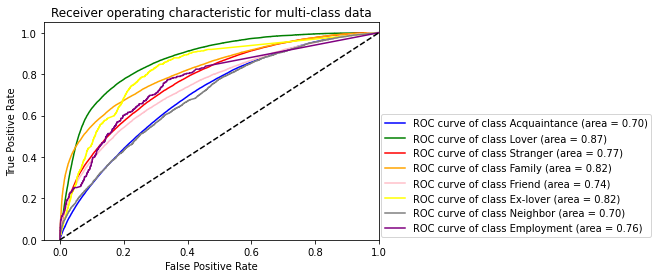

In [16]:
# Reassign
y = murder.Relationship # Target variable

# Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7])
classes = y_bin.shape[1]

# Split dataset into training set and test set
X_train, X_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, test_size=0.3, random_state=1)

# Create Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=89, min_samples_split=2, random_state=0, max_depth=21)

# Train Random Forest Classifier
rf_clf.fit(X_train,y_bin_train)

# Predict the response for test dataset
y_pred_rf = rf_clf.predict(X_test)

# Wrap classifier
classifier = OneVsRestClassifier(rf_clf)
y_pred_proba_rf = classifier.fit(X_train, y_bin_train).predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Construct ROC curve
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_pred_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = itertools.cycle(['blue', 'green', 'red', 'orange', 'pink', 'yellow', 'grey', 'purple'])

for i, color in zip(range(classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(relationships[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(bbox_to_anchor=(0.99, 0.6))
plt.show()

## Comparison ROC curve class 'Lover':                                                             decision tree vs. random forest

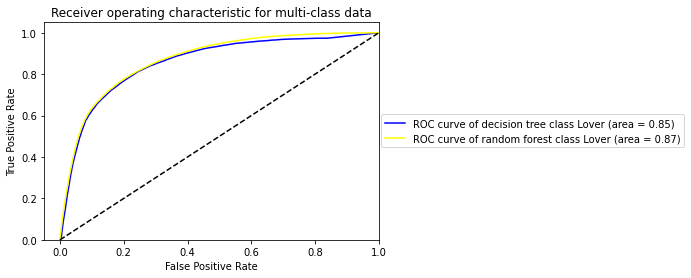

In [17]:
'''
Although this is not further elaborated on throughout the report, this comparison was used to see if there was
a true improvement between the AUC of the decision tree and the random forest, or if there was a trade-off.
We find that there is indeed a true improvement, as the line of the random forest ROC for 'Lover' at all times
remained above the line of the decision tree ROC for 'Lover'.
'''

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=13)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_bin_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Wrap classifier
classifier = OneVsRestClassifier(clf)
y_pred_proba = classifier.fit(X_train, y_bin_train).predict_proba(X_test)

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

# Create Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=89, min_samples_split=2, random_state=0, max_depth=21)

# Train Random Forest Classifier
rf_clf.fit(X_train,y_bin_train)

# Predict the response for test dataset
y_pred_rf = rf_clf.predict(X_test)

# Wrap classifier
classifier2 = OneVsRestClassifier(rf_clf)
y_pred_proba_rf = classifier2.fit(X_train, y_bin_train).predict_proba(X_test)

fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()

# Construct ROC curve for decision tree 
for i in range(classes):
    fpr1[i], tpr1[i], _ = roc_curve(y_bin_test[:, i], y_pred_proba[:, i])
    roc_auc1[i] = auc(fpr1[i], tpr1[i])

# Construct ROC curve for random forest
for i in range(classes):
    fpr2[i], tpr2[i], _ = roc_curve(y_bin_test[:, i], y_pred_proba_rf[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

plt.plot(fpr1[1], tpr1[1], color='blue',label='ROC curve of decision tree class {0} (area = {1:0.2f})'.format(relationships[1], roc_auc1[1]))
plt.plot(fpr2[1], tpr2[1], color='yellow',label='ROC curve of random forest class {0} (area = {1:0.2f})'.format(relationships[1], roc_auc2[1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(bbox_to_anchor=(0.99, 0.6))
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=561f8f84-2db1-4718-81d9-bad66d02bc44' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>